In [1]:
from readImages import readAll
images = readAll('Natural_Images/Resized', '.png')

float32


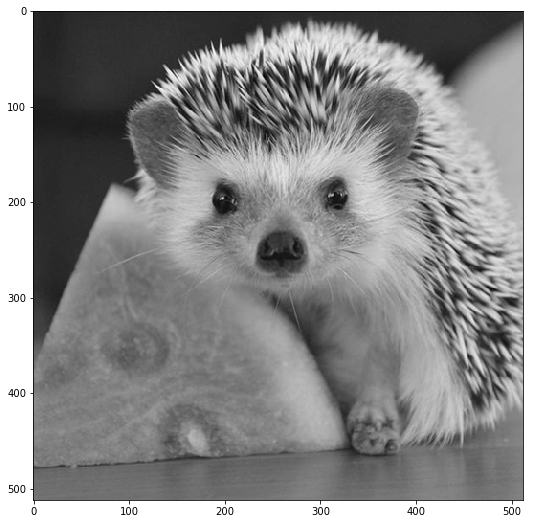

In [2]:
import matplotlib.pyplot as plt
from scipy import misc
%matplotlib inline

plt.rcParams['figure.figsize'] = [16, 9]

plt.imshow(images[3], cmap='gray')

test_image = misc.imread('Natural_Images/Resized/hedgehog2.png', mode='F')
print(test_image.dtype)

In [3]:
from ICA import train_ICA, ICA_decompose
block_size = 8

basis, train, px, py = train_ICA(images, block_size, num_samples=3200)

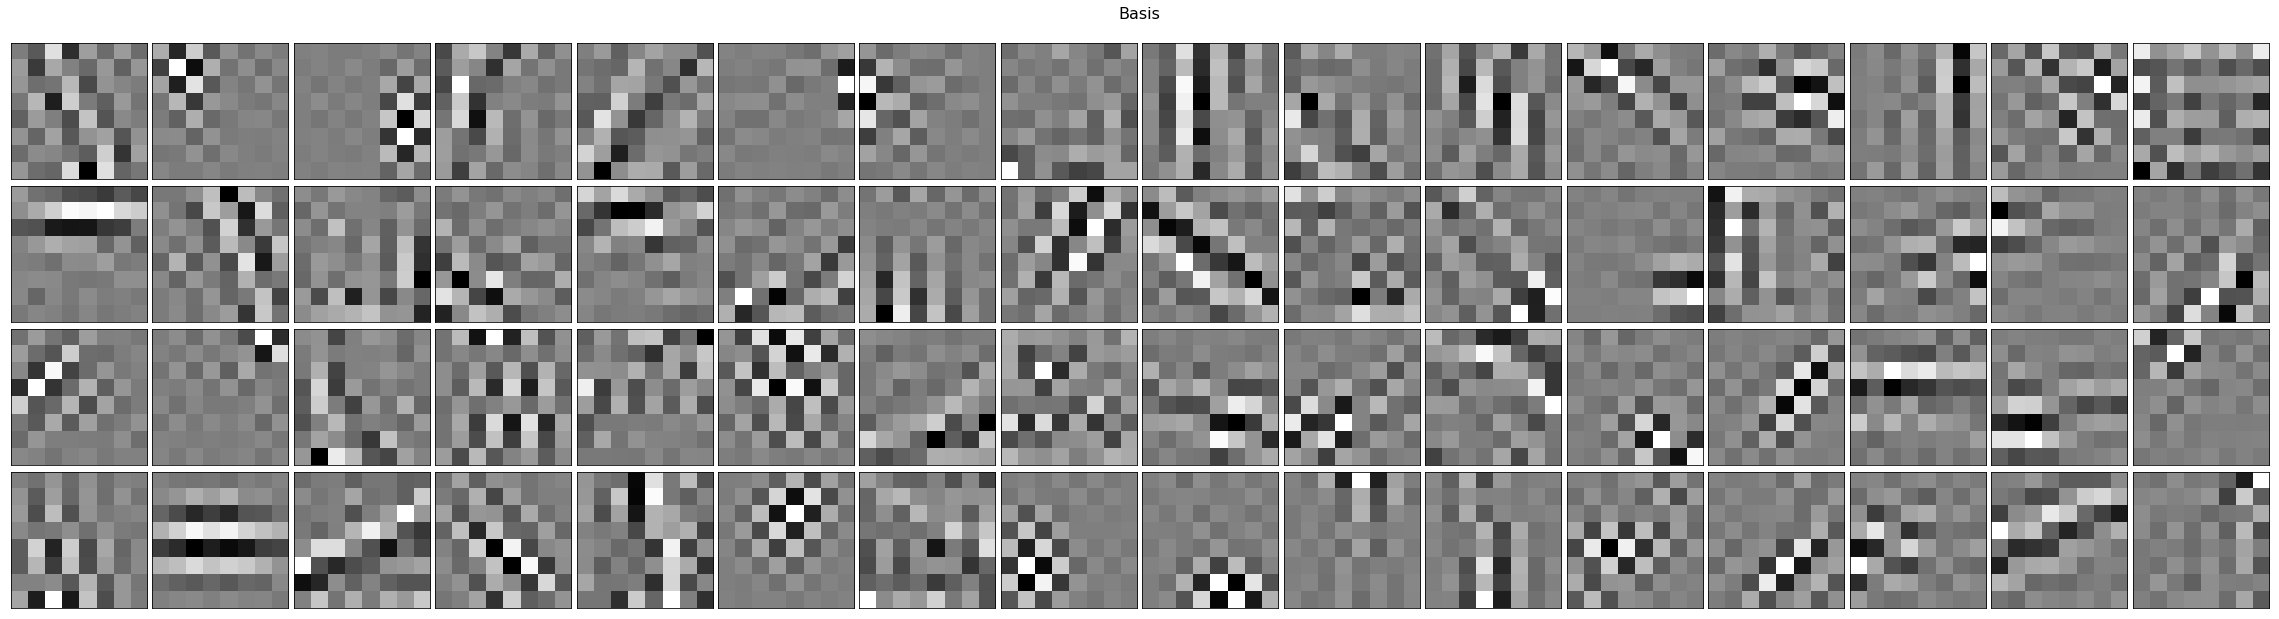

In [4]:
from ICA import plot_gallery
plot_gallery('Basis', basis, n_col=16, n_row=block_size ** 2 / 16, image_shape=(block_size,block_size))

In [5]:
decomposition, intercept, iterations = ICA_decompose(images[3], block_size, basis, 300)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\linear_model\omp.py:391: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)


In [6]:
from ICA import reconstruct
reconstructed_image = reconstruct(decomposition, intercept, basis, block_size, images[3].shape)

In [7]:
print(len(decomposition))

4096


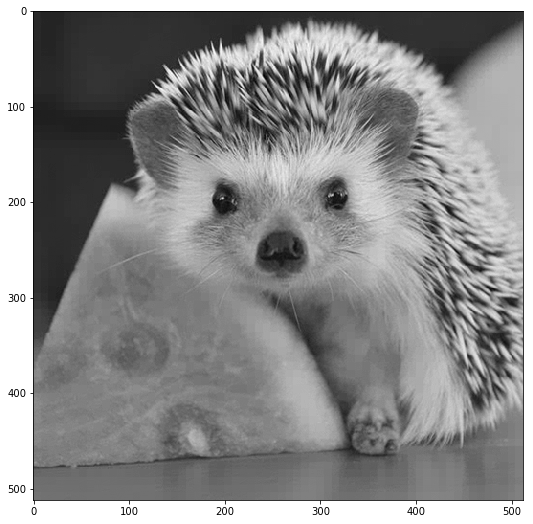

31.9138183594


In [8]:
import numpy as np
plt.imshow(reconstructed_image, cmap='gray')
plt.show()
print(np.mean(iterations))

In [9]:
from scipy.sparse import lil_matrix
block_coeff = []
for dec in decomposition:
    block_coeff.append(dec)
    
block_coeff_sparse = lil_matrix(block_coeff)
bccsr = block_coeff_sparse.tocsr()

In [10]:
print(images[3].nbytes)
print(bccsr.data.nbytes + bccsr.indptr.nbytes + bccsr.indices.nbytes)
print(1.*(bccsr.data.nbytes + bccsr.indptr.nbytes + bccsr.indices.nbytes)/(images[3].nbytes))
print(images[3].dtype)
print(bccsr)

2097152
1585016
0.755794525146
float64
  (0, 18)	5061.22701351
  (1, 57)	-378.54517661
  (2, 52)	-1779.60897896
  (3, 52)	-2063.0275124
  (4, 28)	2511.06734048
  (5, 63)	2200.73713772
  (6, 7)	1093.53696225
  (7, 18)	-1858.48303667
  (8, 27)	-374.972579944
  (9, 7)	1968.20923889
  (10, 15)	-2563.14076333
  (11, 38)	-2590.91951754
  (12, 8)	1435.27962056
  (13, 50)	2979.63863803
  (14, 4)	2593.02946728
  (15, 18)	2147.0980396
  (16, 38)	-2356.0744921
  (17, 50)	-4504.76870011
  (18, 18)	4340.04338841
  (19, 13)	-1619.76335641
  (20, 8)	1146.38157417
  (21, 28)	-1629.39748508
  (22, 13)	-1391.93705913
  (23, 52)	-3376.78492948
  (24, 13)	2029.37807648
  :	:
  (4085, 18)	4686.97304294
  (4086, 9)	-2853.39899406
  (4087, 18)	3720.55211028
  (4088, 1)	-881.776232652
  (4088, 3)	3450.82749163
  (4088, 13)	4216.34706434
  (4088, 18)	26455.4287664
  (4088, 21)	2201.4406644
  (4088, 22)	-2517.53300955
  (4088, 25)	6018.91238102
  (4088, 28)	-17709.9126743
  (4088, 34)	3316.39728147
  (4088, 45)

In [55]:
from sklearn.cluster import KMeans

In [114]:
#"near perfect" reconstruction with 256 colors
#seems to do "very good" with just 64 colors
#seems to do "good" with 32 colors
#experiment with setting this to 16, it does "pretty good"
n_colors = 256   

int_shaped = intercept.reshape(-1,1)       #force 1D array into k-means
kmeans_int = KMeans(n_clusters=n_colors,n_jobs=-1).fit(int_shaped)

In [115]:
#the following 2 data structures will contain the lookup table for colors and the table indices, respectively
# so they are the only things needed to reconstruct the array "intercept"
intercept_lookup = np.ravel(kmeans_int.cluster_centers_)     #contains the lookup table of the floating point color numbers
intercept_compressed = kmeans_int.predict(int_shaped)        #contains numbers from [0..n_colors-1]

#reconstruct intercept in order to display the results after compression
intercept_km = np.array([intercept_lookup[index] for index in intercept_compressed])

In [116]:
from scipy.sparse import *

#can uncomment the next line to use a different number of colors from the intercept
#n_colors = 64

bccsr_shaped = bccsr.data.reshape(-1,1)              #only using the nonzero values of our sparse matrix

#patience -- this takes a while (a couple minutes for 256 colors on 4096 blocks)
kmeans_dec = KMeans(n_clusters=n_colors,n_jobs=-1).fit(bccsr_shaped)

In [117]:
#the following 3 data structures will contain the lookup table for colors and the table indices, respectively
# so they are the only things needed to reconstruct the array "decomposition"
bccsr_indices = bccsr.nonzero()                             #contains the sparse matrix indices
bccsr_lookup = np.ravel(kmeans_dec.cluster_centers_)        #contains the lookup table of the floating point color numbers
bccsr_compressed = kmeans_dec.predict(bccsr_shaped)         #contains numbers from [0..n_colors-1]

#reconstruct intercept in order to display the results after compression
bccsr_values = [bccsr_lookup[index] for index in bccsr_compressed]
bccsr_km = csr_matrix((bccsr_values, (bccsr_indices[0],bccsr_indices[1]))).toarray()

In [118]:
reconstructed_image = reconstruct(bccsr_km, intercept_km, basis, block_size, images[3].shape)

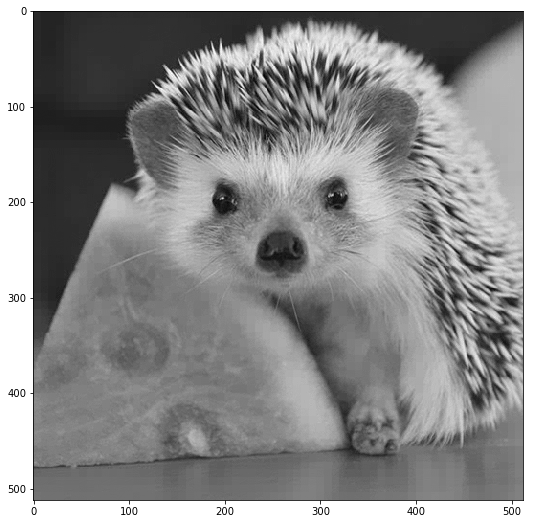

In [119]:
import numpy as np
plt.imshow(reconstructed_image, cmap='gray')
plt.show()